<a href="https://colab.research.google.com/gist/ziadahmed122/b4459725f5c792d550d12cb1aa9161ca/networks-assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import truncnorm as dist

In [0]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening topics and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, size_community=100, adjusting_topic_alpha=0.03, relation_strength_beta=0.3, threshold_gamma=4, global_pressure_factor=0.03,\
                       adjusting_topic_alpha_std=0.0001, relation_strength_beta_std=0.0001, threshold_gamma_std=0.0001, global_pressure_factor_std=0.0001):
        #notice that the values mentioned above are the values that will be set if no other value was specified

        self.size_community = size_community #The number of people in the network. (between 1 and infinty)
        self.adjusting_topic_alpha = adjusting_topic_alpha #how willing are you to change topic based on your neighbours. (between 0 and 1)
        self.relation_strength_beta = relation_strength_beta #the strength of the relationship base on the opinion of both side of the topic (between 0 and 1)
        self.threshold_gamma = threshold_gamma #how picky is the node (between 0 and infinity)
        self.global_pressure_factor = global_pressure_factor #how does the avrage globle change affect the node (between 0 and 1)
        self.adjusting_topic_alpha_std = adjusting_topic_alpha_std #(between 0 and 1)
        self.relation_strength_beta_std = relation_strength_beta_std #(between 0 and 1)
        self.threshold_gamma_std = threshold_gamma_std #(between 0 and 1)
        self.global_pressure_factor_std = global_pressure_factor_std #(between 0 and 1)
        self.average_topic= [] # a list containing the topics on which people have opinions 

    def initialize(self):
        '''
        start the simulation with the respective intial conditions
        Notice that this part is motivated by the professor code 
        '''
        #intiate the graph (the network)
        self.network = nx.barabasi_albert_graph(self.size_community, 3)
        #intiate the edges (the relationship between people in the network)
        for edge in self.network.edges:
            self.network.edges[edge]['weight'] = 0.5
            self.network.edges[edge]['relation_strength_beta'] = dist.rvs(a=0, b=1, loc=self.relation_strength_beta, scale=self.relation_strength_beta_std, size=1)[0]
            self.network.edges[edge]['threshold_gamma'] = dist.rvs(a=0, b=1 + self.network.edges[edge]['relation_strength_beta']**(-1),\
                                                       loc=self.threshold_gamma, scale=self.threshold_gamma_std, size=1)[0]
        #intiate the nodes (the people in the network)                                              
        for node in self.network.nodes:
            self.network.nodes[node]['topic'] = random.randint(0, 1)
            self.network.nodes[node]['adjusting_topic_alpha'] = dist.rvs(a=0, b=1, loc=self.adjusting_topic_alpha, scale=self.adjusting_topic_alpha_std, size=1)[0]
            self.network.nodes[node]['global_pressure_factor'] = dist.rvs(a=0, b=1, loc=self.global_pressure_factor, scale=self.global_pressure_factor_std, size=1)[0]
        self.layout = nx.spring_layout(self.network)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Visualize the state of the network based on the nodes and edges colors
        Notice that this part is motivated by the professor code 
        '''
        self.layout = nx.spring_layout(self.network, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.network, pos=self.layout, with_labels=True,
            node_color=[self.network.nodes[i]['topic'] for i in self.network.nodes],
            edge_color=[self.network.edges[i, j]['weight'] for i, j in self.network.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            adjusting_topic_alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        '''
        Update the model based on the inital conditions and the roles 
        '''
        if random.uniform(0, 1) < 0.01:
            # make new adges between the nodes with a strength of the difference between thier opinion around the tpoic
            nodes = list(self.network.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.network.edges:
                    break
            if self.network.nodes[new_edge[0]]['topic'] == 0 or self.network.nodes[new_edge[1]]['topic'] == 0:
                new_weight = 0
            else: 
                new_weight = self.network.nodes[new_edge[0]]['topic']/self.network.nodes[new_edge[1]]['topic']
            if new_weight > 1: 
                new_weight = 1/new_weight
            self.network.add_edge(new_edge[0], new_edge[1], weight=new_weight)
            self.network.edges[new_edge]['weight'] = 0.5
            self.network.edges[new_edge]['relation_strength_beta'] = dist.rvs(a=0, b=1, loc=self.relation_strength_beta, scale=self.relation_strength_beta_std, size=1)[0]
            self.network.edges[new_edge]['threshold_gamma'] = dist.rvs(a=0, b=1 + self.network.edges[new_edge]['relation_strength_beta']**(-1),\
                                                       loc=self.threshold_gamma, scale=self.threshold_gamma_std, size=1)[0]
        else:
            # Choosing a random edge to update its value and the opinions of the nodes attached to it 
            edge = random.choice(list(self.network.edges))
            weight = self.network.edges[edge]['weight']
            topics = [self.network.nodes[n]['topic'] for n in edge]
            average_topic= np.mean([self.network.nodes[i]['topic'] for i in self.network.nodes])
            for i in [0, 1]:
                self.network.nodes[edge[i]]['topic'] = (
                    topics[i] + self.network.nodes[edge[i]]['adjusting_topic_alpha'] * weight * (topics[1-i] - topics[i])
                    + self.network.nodes[edge[i]]['global_pressure_factor']*(average_topic- topics[i]))
            self.network.edges[edge]['weight'] = (weight +\
                                                self.network.edges[edge]['relation_strength_beta'] * weight * (1-weight) *\
                                                (1 - self.network.edges[edge]['threshold_gamma'] * abs(topics[0] - topics[1])))
            # putting a threshold of 0.05 and consider edges below it as weak enough to not be considered 
            if self.network.edges[edge]['weight'] < 0.05:
                self.network.remove_edge(*edge)
        #keeping track of the time steps
        self.step += 1
        #Get the avrage opinion of the globle collective for the next step 
        average_topic= np.mean([self.network.nodes[i]['topic'] for i in self.network.nodes])
        self.average_topic.append(average_topic)
        #Plotting the average opinion graph that indicate the state of the globle collective opinion over time 
    def plot_average(self): 
        plt.figure(figsize=(12,8))
        plt.plot(range(self.step), self.average_topic)
        plt.title('Average Opinion: adjusting_topic_alpha {}, relation_strength_beta {}, threshold_gamma {}, global_pressure_factor {}, std {}'.format(self.adjusting_topic_alpha, self.relation_strength_beta,\
                                                                                        self.threshold_gamma, self.global_pressure_factor,\
                                                                                        self.adjusting_topic_alpha_std))
        plt.ylabel('topic')
        plt.xlabel('Time step')
        plt.show()

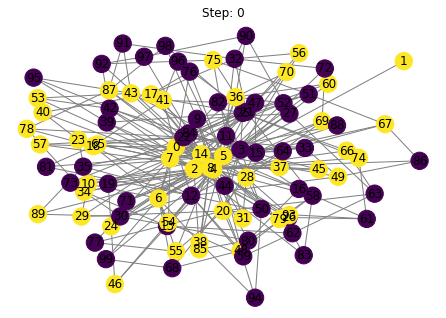

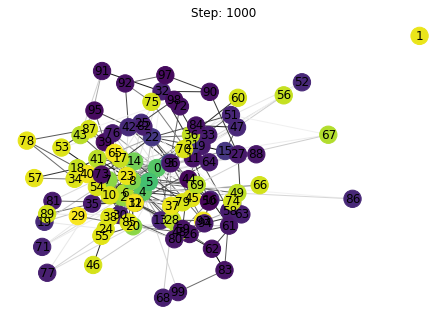

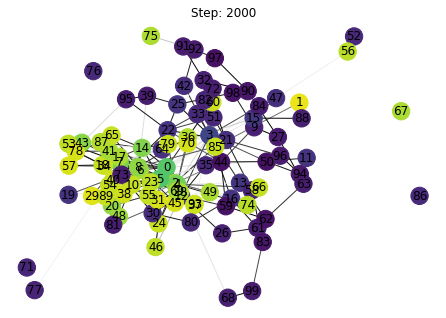

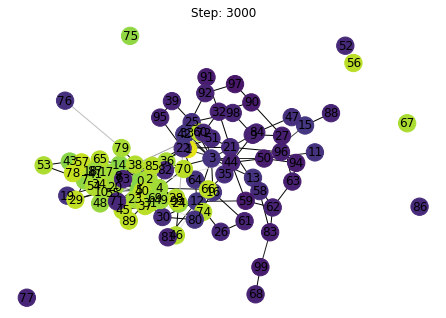

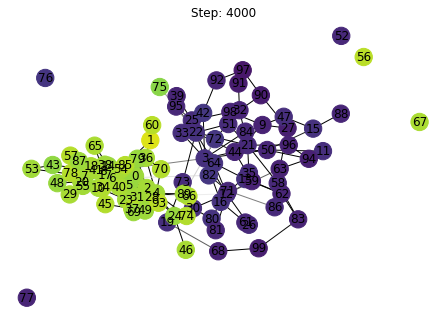

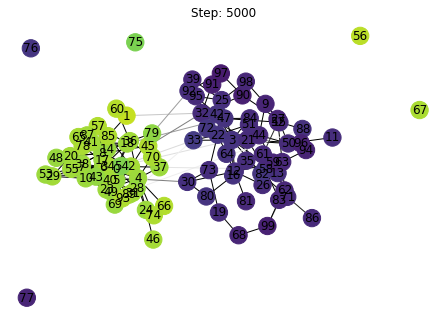

In [3]:
simulation = SocialDynamicsSimulation(adjusting_topic_alpha=0.03, relation_strength_beta=0.3, threshold_gamma=3.5, global_pressure_factor=0,adjusting_topic_alpha_std=0.01, relation_strength_beta_std=0.01, threshold_gamma_std=0.01, global_pressure_factor_std=0.001)
simulation.initialize()
plt.figure()
simulation.observe()
for i in range(5):
    for i in range(1000): #number of updates before taking a screen shot as a graph 
        simulation.update()
    plt.figure()
    simulation.observe()

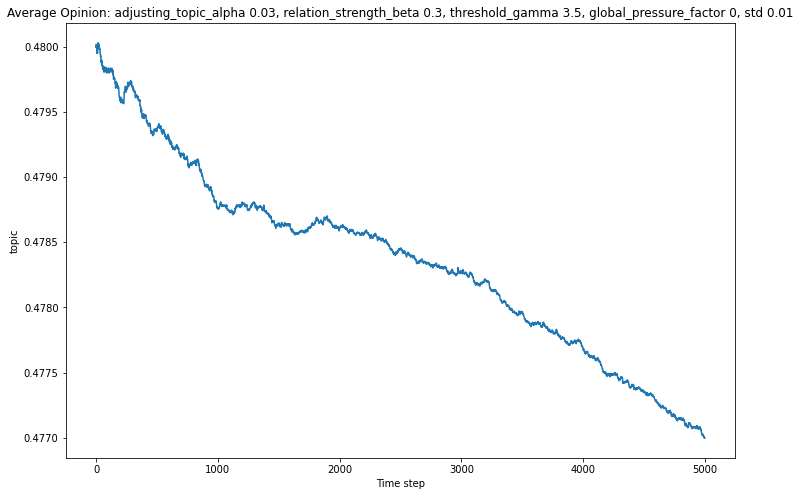

In [4]:
simulation.plot_average()

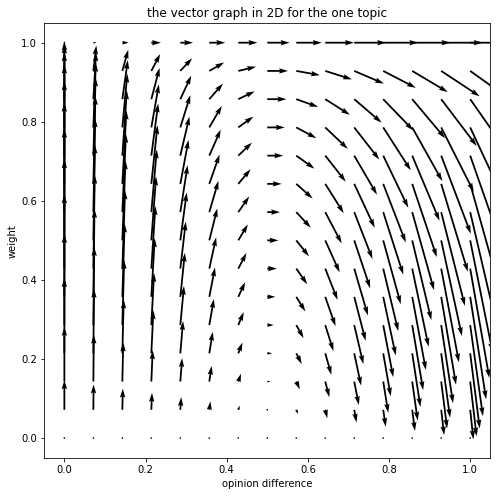

In [5]:
#2D field
adjusting_topic_alpha = 0.05
relation_strength_beta = 0.5
threshold_gamma = 2

#initiate a grid with two topics on  the acess
topic_difference = np.linspace(0, 1, 15)
relation_weight = np.linspace(0, 1, 15)
opinion_difference_grid, weight_grid = np.meshgrid(topic_difference, relation_weight)

# calculate the vector field
x_axis_vector = adjusting_topic_alpha*weight_grid*opinion_difference_grid
y_axis_vector = relation_strength_beta*weight_grid*(1-weight_grid)*(1-threshold_gamma*opinion_difference_grid)

# Plot
plt.figure(figsize=(8, 8))
plt.quiver(opinion_difference_grid, weight_grid, x_axis_vector, y_axis_vector, scale=0.5)
plt.title('the vector graph in 2D for the one topic')
plt.xlabel('opinion difference')
plt.ylabel('weight')
plt.show()

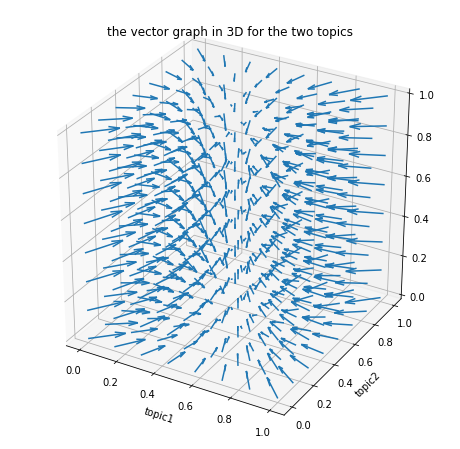

In [6]:
#The 3D field 
#%matplotlib notebook 
adjusting_topic_alpha = 0.05 
relation_strength_beta = 0.3
threshold_gamma = 2
global_pressure_factor = 0.5
opinion_avrage = 0.5

#initiate a grid with two topics on  the acess
topic_1 = np.linspace(0, 1, 8)
topic_2 = np.linspace(0, 1, 8)
relation_weight = np.linspace(0, 1, 8)

x_value, y_value, z_value = np.meshgrid(topic_1, topic_2, relation_weight)

# intiate grid
x_axis_vector = adjusting_topic_alpha*z_value*(x_value-y_value) + global_pressure_factor*(opinion_avrage - x_value)
y_axis_vector = adjusting_topic_alpha*z_value*(y_value-x_value) + global_pressure_factor*(opinion_avrage - y_value)
z_axis_vector = relation_strength_beta*z_value*(1-z_value)*(1-threshold_gamma*np.abs(x_value-y_value))

# Plot
plt.figure(figsize=(8, 8))
plt.gca(projection='3d')
plt.quiver(x_value, y_value, z_value, x_axis_vector, y_axis_vector, z_axis_vector, length=0.5)
plt.title('the vector graph in 3D for the two topics')
plt.xlabel('topic1')
plt.ylabel('topic2')
plt.show()

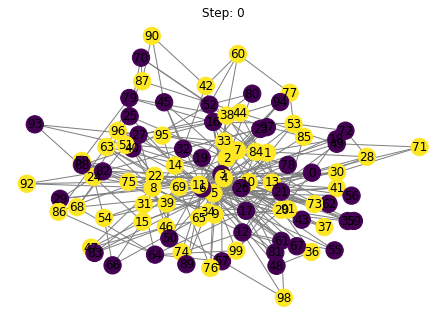

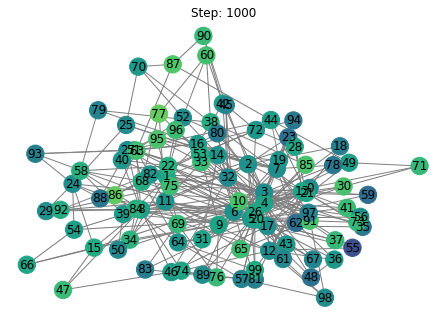

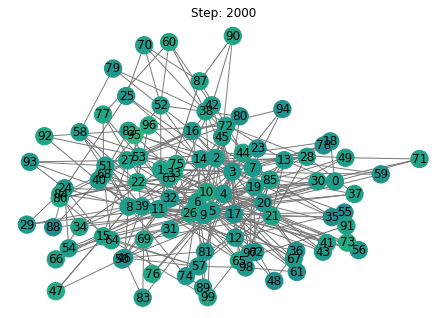

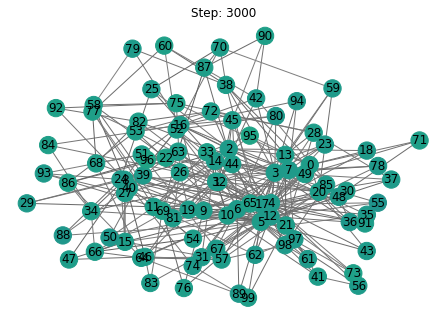

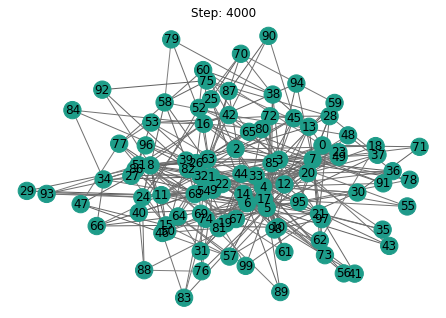

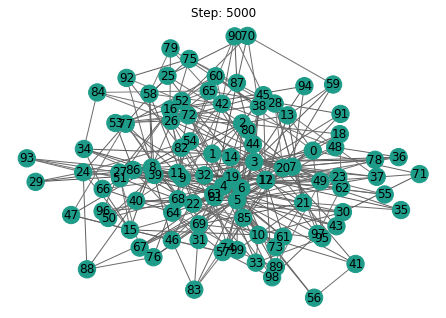

In [7]:
#trail 2
#switch the values of alpha and beta 
simulation = SocialDynamicsSimulation(adjusting_topic_alpha=0.3, relation_strength_beta=0.03, threshold_gamma=3.5, global_pressure_factor=0,adjusting_topic_alpha_std=0.01, relation_strength_beta_std=0.01, threshold_gamma_std=0.01, global_pressure_factor_std=0.001)
simulation.initialize()
plt.figure()
simulation.observe()
for i in range(5):
    for i in range(1000): #number of updates before taking a screen shot as a graph 
        simulation.update()
    plt.figure()
    simulation.observe()

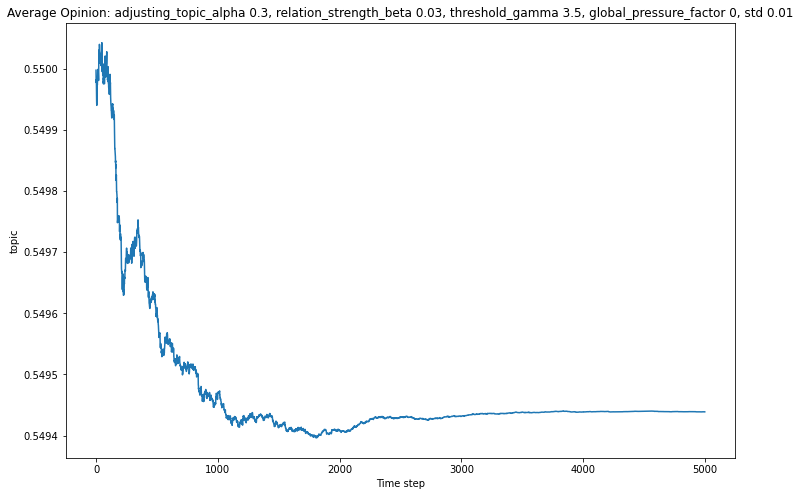

In [8]:
simulation.plot_average()

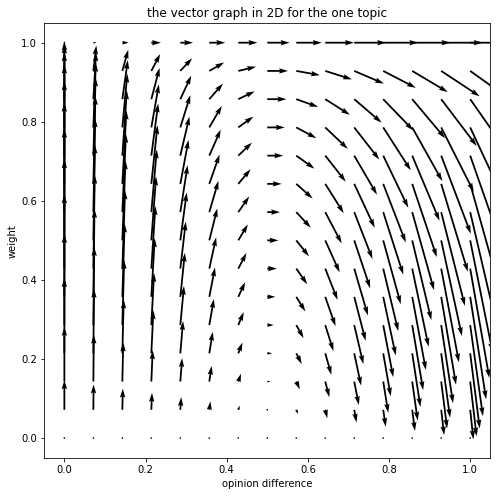

In [9]:
#2D field
adjusting_topic_alpha = 0.05
relation_strength_beta = 0.5
threshold_gamma = 2

#initiate a grid with two topics on  the acess
topic_difference = np.linspace(0, 1, 15)
relation_weight = np.linspace(0, 1, 15)
opinion_difference_grid, weight_grid = np.meshgrid(topic_difference, relation_weight)

# calculate the vector field
x_axis_vector = adjusting_topic_alpha*weight_grid*opinion_difference_grid
y_axis_vector = relation_strength_beta*weight_grid*(1-weight_grid)*(1-threshold_gamma*opinion_difference_grid)

# Plot
plt.figure(figsize=(8, 8))
plt.quiver(opinion_difference_grid, weight_grid, x_axis_vector, y_axis_vector, scale=0.5)
plt.title('the vector graph in 2D for the one topic')
plt.xlabel('opinion difference')
plt.ylabel('weight')
plt.show()

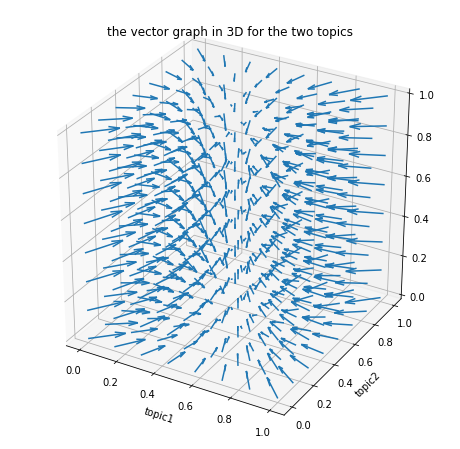

In [10]:
#The 3D field 
#%matplotlib notebook 
adjusting_topic_alpha = 0.05 
relation_strength_beta = 0.3
threshold_gamma = 2
global_pressure_factor = 0.5
opinion_avrage = 0.5

#initiate a grid with two topics on  the acess
topic_1 = np.linspace(0, 1, 8)
topic_2 = np.linspace(0, 1, 8)
relation_weight = np.linspace(0, 1, 8)

x_value, y_value, z_value = np.meshgrid(topic_1, topic_2, relation_weight)

# intiate grid
x_axis_vector = adjusting_topic_alpha*z_value*(x_value-y_value) + global_pressure_factor*(opinion_avrage - x_value)
y_axis_vector = adjusting_topic_alpha*z_value*(y_value-x_value) + global_pressure_factor*(opinion_avrage - y_value)
z_axis_vector = relation_strength_beta*z_value*(1-z_value)*(1-threshold_gamma*np.abs(x_value-y_value))

# Plot
plt.figure(figsize=(8, 8))
plt.gca(projection='3d')
plt.quiver(x_value, y_value, z_value, x_axis_vector, y_axis_vector, z_axis_vector, length=0.5)
plt.title('the vector graph in 3D for the two topics')
plt.xlabel('topic1')
plt.ylabel('topic2')
plt.show()